In [1]:
import numpy as np
import torch
import copy
import torch.nn.functional as F
from torch.nn import DataParallel

from torch import nn, optim
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
multi_gpus = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    multi_gpus = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class SEBlock(nn.Module):

  def __init__(self, planes, ratio):

      super(SEBlock, self).__init__()

      self.se_pool = nn.AdaptiveAvgPool2d((1,1))
      self.se_fc1 = nn.Linear(planes, planes // ratio)
      self.relu = nn.ReLU(inplace=True)
      self.se_fc2 = nn.Linear(planes // ratio, planes)

  def forward(self, x):

      out = self.se_pool(x)
      out = torch.flatten(out, 1)
      out = self.se_fc1(out)
      #print(out.shape)
      out = F.relu(out)
      out = self.se_fc2(out)
      out = torch.sigmoid(out)
      out = out.view(out.size(0), out.size(1), 1, 1)
      #print(x.shape)
      #print(out.shape)
      out = torch.mul(out.expand_as(x), x)

      return out

In [4]:
class ConvBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=True):

        super(ConvBlock, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        pad = 0
        if padding :
            pad = (self.kernel_size - 1) // 2

        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding=pad, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_planes, momentum=0.99)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):

        output = self.conv(x)
        output = self.batchnorm(output)
        output = self.leaky_relu(output)

        return output

In [5]:
class DarknetBlock(nn.Module):

    def __init__(self, out_planes):

        super(DarknetBlock, self).__init__()
        self.inplanes = out_planes * 2
        self.conv1 = ConvBlock(self.inplanes, out_planes, 1)
        self.conv2 = ConvBlock(out_planes, self.inplanes, 3)
        self.se = SEBlock(self.inplanes, ratio=16)

    def forward(self, x):

        shortcut = x
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.se(output)
        output = output + shortcut

        return output

In [6]:
class Darknet(nn.Module):

    def __init__(self, num_classes=1000):

        super(Darknet, self).__init__()   

        self.conv_block1 = ConvBlock(3, 32, 3, 1)
        self.conv_block2 = ConvBlock(32, 64, 3, 2)

        self.dark_block1 = DarknetBlock(32)

        self.conv_block3 = ConvBlock(64, 128, 3, 2)

        self.dark_layer1 = self._make_blocks(2, 64)
        
        self.conv_block4 = ConvBlock(128, 256, 3, 2)

        self.dark_layer2 = self._make_blocks(2, 128)

        self.conv_block5 = ConvBlock(256, 512, 3, 2)

        self.dark_layer3 = self._make_blocks(2, 256)

        self.conv_block6 = ConvBlock(512, 1024, 3, 2)

        self.dark_layer4 = self._make_blocks(2, 512)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc = nn.Linear(1024, num_classes)

    def _make_blocks(self, num_blocks, out_planes):
        blocks = []
        for _ in range(num_blocks):
            blocks.append(DarknetBlock(out_planes))

        return nn.Sequential(*blocks)

    def forward(self, x, feature=False):

        output = self.conv_block1(x)
        output = self.conv_block2(output)

        output = self.dark_block1(output)

        output = self.conv_block3(output)

        output = self.dark_layer1(output)

        output = self.conv_block4(output)

        output = self.dark_layer2(output)

        output = self.conv_block5(output)

        output = self.dark_layer3(output)

        output = self.conv_block6(output)

        output = self.dark_layer4(output)

        output = self.avgpool(output)

        output = torch.flatten(output, 1)
        
        if feature:
            return output

        output = self.fc(output)
        
        return output

In [7]:
model = Darknet(num_classes=4)

In [8]:
inputs = torch.randn((1,3,256,256))
outputs = model(inputs)

In [9]:
outputs.shape

torch.Size([1, 4])

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
count_parameters(model)

20605720

In [13]:
checkpoint = torch.load('./checkpoint/pose_ep015.b0.pth', map_location=torch.device('cpu'))

In [12]:
import apex
print("using apex synced BN")
model = apex.parallel.convert_syncbn_model(model)

using apex synced BN


In [13]:
optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.9, weight_decay=1e-4, nesterov=True)

In [14]:
from apex import amp, optimizers

model, optimizer = amp.initialize(model.cuda(), optimizer, opt_level='O3',keep_batchnorm_fp32=True)

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : False
loss_scale             : 1.0


In [16]:
import torchvision
from torchvision import datasets, transforms

def get_transform(train=True):
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
    transform = []
    #transform.append(transforms.Resize([224,224]))
    if train:
        transform.append(transforms.Resize([256,256]))        
        transform.append(transforms.RandomCrop(224))
        #transform.append(transforms.RandomHorizontalFlip())
    else:
        transform.append(transforms.Resize([224,224]))

    transform.append(transforms.ToTensor())
    transform.append(normalize)
    return transforms.Compose(transform)

class CustomDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image_id, sample, target) where target is class_index of
                the target class.
        """
        path, target = self.samples[index]
        #print(path)
        #print(target)
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        image_id = path.split('/')[-1]

        return image_id, sample, target

In [17]:
from torch.utils import data

data_dir = 'data/pose'

train_dataset = CustomDataset(data_dir, transform=get_transform(train=True))
val_dataset = CustomDataset(data_dir, transform=get_transform(train=False))

In [18]:
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))


In [19]:
np.random.shuffle(indices)

In [20]:
from torch.utils.data.sampler import SubsetRandomSampler


train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [21]:
tr_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=256,
                            sampler = train_sampler,
                            #shuffle=True,
                            pin_memory=True,
                            num_workers=16)

val_loader = data.DataLoader(dataset=val_dataset,
                             batch_size=16,
                             sampler=valid_sampler,
                             #shuffle=False,
                             pin_memory=True,                             
                             num_workers=16)

In [22]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    _ = plt.figure(figsize=(15,15))

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

tensor([3, 2, 1, 3, 3, 0, 3, 0, 0, 1, 2, 3, 2, 0, 3, 2, 3, 1, 2, 2, 1, 1, 3, 2,
        1, 0, 3, 2, 1, 1, 0, 3, 3, 1, 0, 2, 0, 3, 1, 3, 2, 3, 3, 2, 0, 0, 1, 0,
        0, 3, 2, 3, 2, 2, 1, 1, 0, 1, 0, 0, 2, 3, 3, 0, 1, 2, 2, 2, 3, 3, 0, 3,
        0, 1, 2, 0, 2, 2, 1, 2, 0, 0, 1, 2, 0, 1, 0, 1, 3, 0, 2, 1, 1, 3, 1, 0,
        1, 2, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 2, 2, 0, 3, 3, 3, 0, 1, 2, 2, 0, 2,
        2, 2, 3, 0, 1, 0, 1, 1, 0, 3, 1, 1, 3, 2, 3, 0, 1, 0, 1, 3, 1, 1, 3, 1,
        3, 1, 2, 1, 2, 2, 2, 1, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 2, 1, 0, 1, 0, 1,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 3, 0, 2, 2, 3, 1, 0, 1, 1, 2,
        2, 1, 1, 3, 0, 3, 0, 2, 0, 3, 1, 1, 3, 1, 3, 2, 1, 1, 3, 2, 2, 1, 3, 3,
        0, 0, 1, 1, 2, 0, 2, 0, 0, 2, 0, 3, 1, 0, 0, 3, 3, 0, 1, 3, 0, 1, 3, 0,
        2, 1, 3, 1, 3, 3, 0, 3, 1, 3, 2, 1, 2, 2, 1, 1])


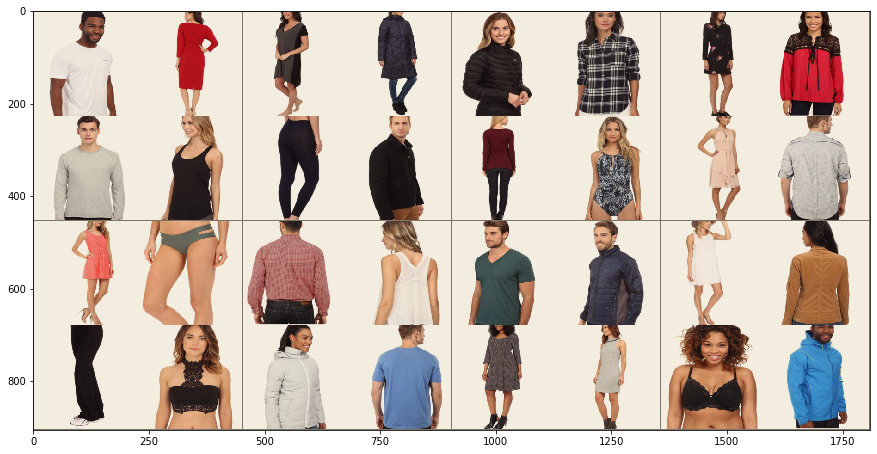

In [23]:


_, inputs, labels = next(iter(tr_loader))

out = torchvision.utils.make_grid(inputs[:32])
print(labels)

imshow(out)

In [24]:
len(tr_loader)

520

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
criterion = nn.CrossEntropyLoss().cuda()

In [27]:
torch.cuda.synchronize()
model.train()
for _ in range(2):
    _, inputs, labels = next(iter(tr_loader))
    print(1)
    inputs = inputs.cuda(non_blocking=True)        
    labels = labels.cuda(non_blocking=True)    
    print(2)    
    logits = model(inputs)
    print(3)                       
    loss = criterion(logits, labels)                   
    print(4)                   
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()
    print(5)                            
    model.zero_grad()
    print(10)                                
torch.cuda.synchronize()

1
2
3
4
5
10
1
2
3
4
5
10


In [28]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [29]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [37]:
t_float = 0.000000123123
print("{},{:.10f}".format('test', t_float))

test,0.0000001231


In [38]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(tr_loader)
                                                , epochs=15, pct_start=0.2)

In [39]:
def classification_val(model, val_loader):
    correct = 0
    total = 0    
    
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            _, images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            loss += loss.item()
            correct += (predicted == labels).sum().item()
            #print(loss.item()/inputs.size(0))
    return correct/total, loss.cpu()

In [40]:
import datetime
import time
high = 0.0
epoch_time = AverageMeter('Epoch', ':6.3f')
batch_time = AverageMeter('Batch', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
losses = AverageMeter('Loss', ':.5f')
learning_rates = AverageMeter('LearningRate', ':.5f')
top1 = AverageMeter('Acc@1', ':6.2f')
#top5 = AverageMeter('Acc@5', ':6.2f')

for epoch in range(15):  # loop over the dataset multiple times
    time_ = datetime.datetime.now()    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    progress = ProgressMeter(
        len(tr_loader),
        [batch_time, data_time, losses, top1, learning_rates],
        prefix="Epoch: [{}]".format(epoch))
    
    end = time.time()    
    for i, (_, inputs, labels) in enumerate(tr_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #print(inputs.shape)
        #print(labels.shape)
        data_time.update(time.time() - end)
        inputs = inputs.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #_, preds = torch.max(outputs, 1)
        #loss.backward()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
            
        optimizer.step()
        scheduler.step()
        # print statistics
        acc1, acc5 = accuracy(outputs, labels, topk=(1,1))
        losses.update(loss.item(), inputs.size(0))
        learning_rates.update(scheduler.get_lr()[0])        
        top1.update(acc1[0], inputs.size(0))
        #top5.update(acc5[0], inputs.size(0))

        
        batch_time.update(time.time() - end)
        if i % 100 == 99:    # print every 2000 mini-batches
            progress.display(i)
            #running_loss = 0.0
    elapsed = datetime.datetime.now() - time_
    val_acc, val_loss = classification_val(model, val_loader)
    print('{} elapsed for {} val acc : {}, val loss : {:.5f}'.format(elapsed, epoch+1, val_acc, val_loss))

    
print('Finished Training')

Epoch: [0][ 99/520]	Batch 248.802 (130.897)	Data 248.509 (130.598)	Loss 0.84611 (1.23554)	Acc@1  67.97 ( 44.12)	LearningRate 0.00497 (0.00433)
Epoch: [0][199/520]	Batch 465.194 (242.224)	Data 464.901 (241.927)	Loss 0.28907 (0.84371)	Acc@1  90.62 ( 64.31)	LearningRate 0.00785 (0.00530)
Epoch: [0][299/520]	Batch 681.600 (353.276)	Data 681.306 (352.980)	Loss 0.23434 (0.65209)	Acc@1  92.97 ( 73.39)	LearningRate 0.01251 (0.00688)
Epoch: [0][399/520]	Batch 893.781 (463.995)	Data 893.487 (463.700)	Loss 0.15273 (0.54400)	Acc@1  93.75 ( 78.42)	LearningRate 0.01877 (0.00905)
Epoch: [0][499/520]	Batch 1131.992 (574.865)	Data 1131.698 (574.570)	Loss 0.12851 (0.47293)	Acc@1  95.31 ( 81.62)	LearningRate 0.02637 (0.01174)
0:19:03.546813 elapsed for 1 val acc : 0.9182913620362848, val loss : 0.13403
Epoch: [1][ 99/520]	Batch 36.910 (503.796)	Data 36.613 (503.498)	Loss 0.17386 (0.41612)	Acc@1  94.53 ( 84.14)	LearningRate 0.03684 (0.01557)
Epoch: [1][199/520]	Batch 66.593 (441.031)	Data 66.299 (440.734)

In [29]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,    
    
}, './checkpoint/pose_ep015.b0.pth')

In [14]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [41]:
import glob
from torch.utils.data import Dataset, DataLoader

def test_transform(random_crop=True):
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
    transform = []
    transform.append(transforms.Resize([224, 224]))

    transform.append(transforms.ToTensor())
    transform.append(normalize)
    return transforms.Compose(transform)

class TestDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = glob.glob(root_dir + '*.jpg')
        print(len(self.file_list))
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.file_list[idx]
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [47]:
test_dir = 'data/pose-orig/'
org_dataset = TestDataset(test_dir, transform=test_transform(random_crop=False))


27


In [48]:
from torch.utils import data

org_loader = data.DataLoader(dataset=org_dataset, batch_size=4,)

In [49]:
images = next(iter(org_loader))
print(images.shape)

torch.Size([4, 3, 224, 224])


tensor([2, 3, 2, 2], device='cuda:0')


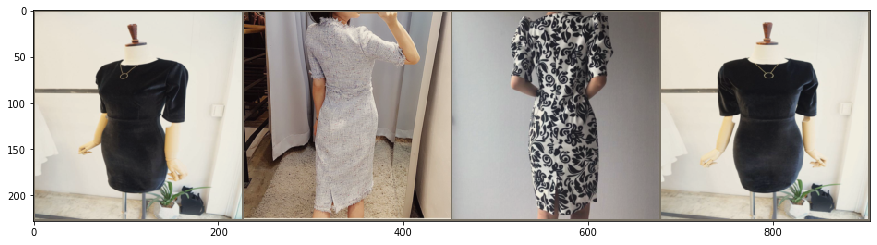

tensor([3, 0, 3, 3], device='cuda:0')


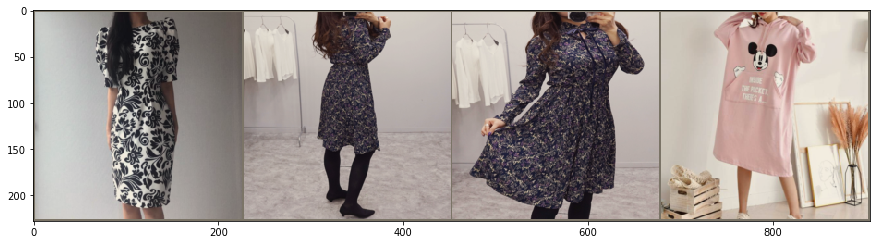

tensor([0, 2, 0, 2], device='cuda:0')


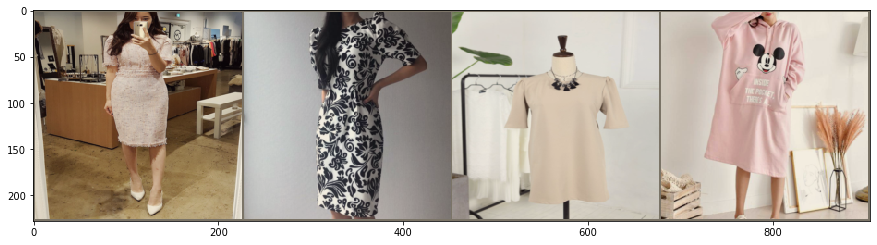

tensor([3, 3, 0, 2], device='cuda:0')


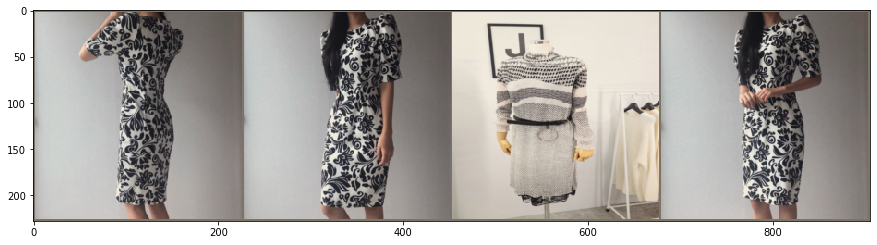

tensor([3, 2, 2, 3], device='cuda:0')


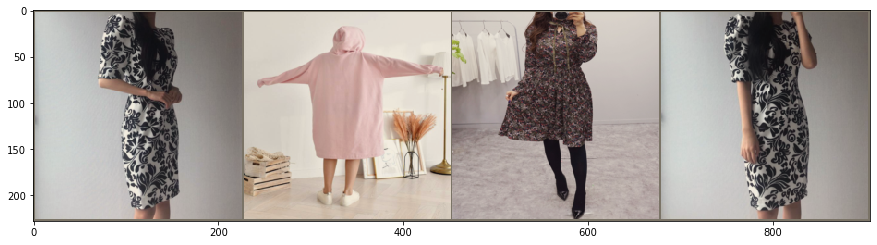

tensor([2, 2, 3, 2], device='cuda:0')


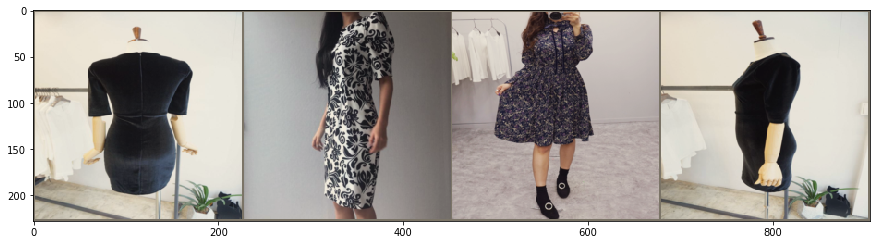

tensor([3, 2, 2], device='cuda:0')


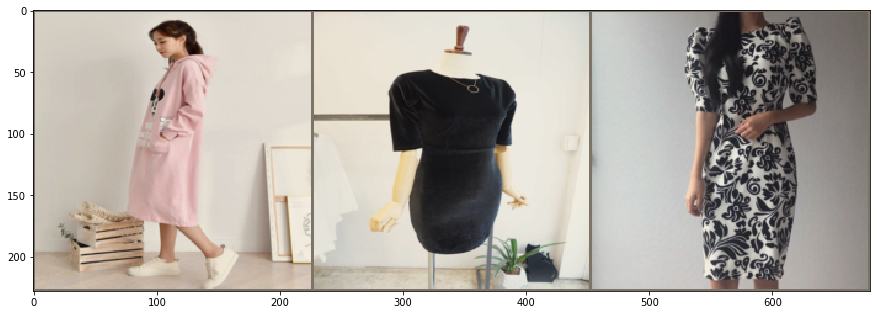

In [50]:
model.eval()
with torch.no_grad():
    for images in org_loader:
        images = images.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        out = torchvision.utils.make_grid(images.cpu())
        imshow(out)

tensor([3, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0])


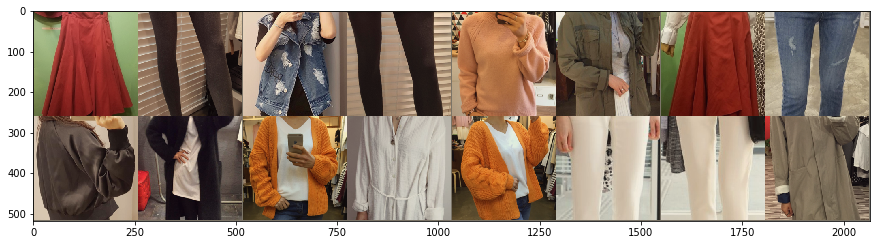

tensor([0, 0, 2, 0, 0, 0, 0, 2, 3, 3, 0, 0, 2, 2, 0, 0])


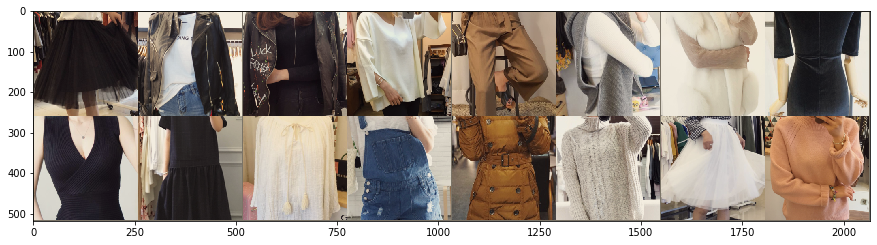

In [25]:
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        out = torchvision.utils.make_grid(images.cpu())
        imshow(out)


tensor([3, 0, 2, 3, 1, 0, 2, 3, 2, 2, 3, 2, 3, 1, 1, 1])
tensor([3, 0, 2, 3, 1, 0, 2, 3, 2, 2, 3, 2, 3, 1, 1, 1], device='cuda:0')
torch.Size([16])


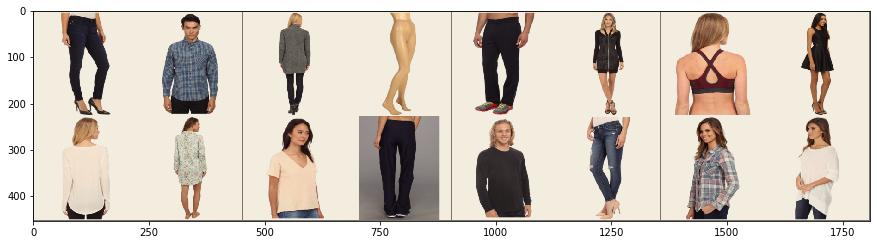

tensor([3, 1, 3, 0, 2, 0, 1, 0, 3, 1, 3, 3, 1, 0, 3, 2])
tensor([3, 1, 3, 0, 2, 0, 1, 0, 3, 1, 3, 2, 0, 0, 3, 2], device='cuda:0')
torch.Size([16])


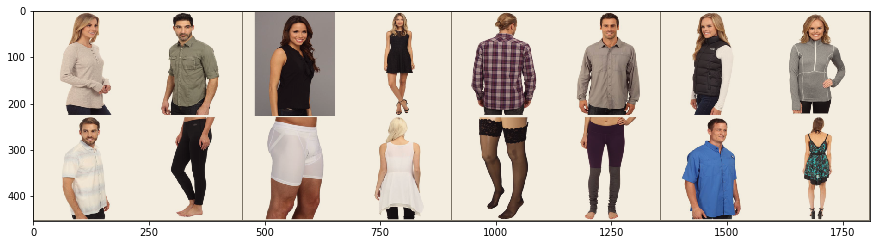

tensor([3, 3, 0, 1, 0, 2, 3, 1, 0, 2, 0, 1, 1, 3, 1, 1])
tensor([3, 3, 0, 1, 0, 2, 3, 1, 0, 2, 0, 1, 1, 3, 1, 1], device='cuda:0')
torch.Size([16])


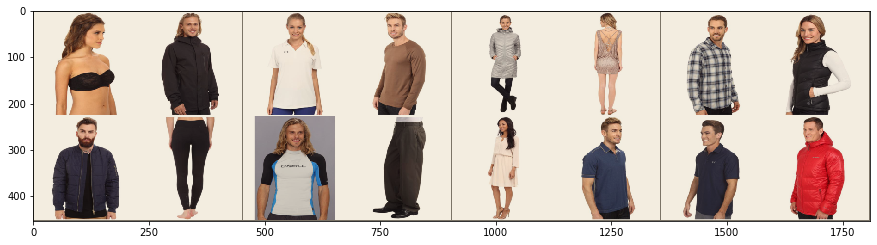

tensor([1, 1, 1, 1, 3, 2, 0, 2, 0, 2, 0, 0, 2, 2, 1, 3])
tensor([1, 1, 1, 1, 3, 2, 0, 0, 0, 2, 0, 0, 2, 2, 1, 3], device='cuda:0')
torch.Size([16])


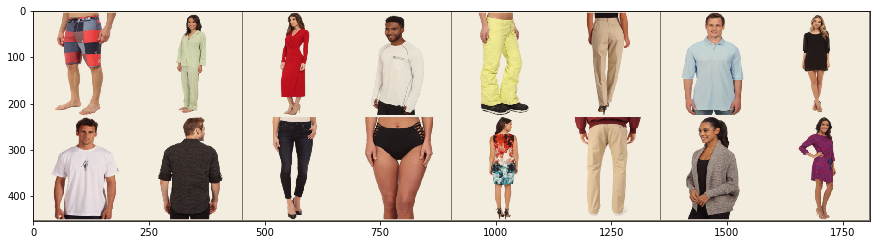

In [46]:
model.eval()
with torch.no_grad():

    for i, data in enumerate(val_loader):

        _, inputs, labels = data
        inputs = inputs.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        print(labels)
        print(predicted)
        print(predicted.shape)
        out = torchvision.utils.make_grid(inputs.cpu())
        imshow(out)    
        if i == 3 :
            break

In [ ]:
def classification_val(model, val_loader):
    correct = 0
    total = 0    
    
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            _, images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            loss += loss.item()
            correct += (predicted == labels).sum().item()
            #print(loss.item()/inputs.size(0))
    return correct/total, loss.cpu()/total

In [29]:
def val_retrieval(model, val_loader):
    feats = None
    data_ids = None

    model.eval()
    with torch.no_grad():
        for idx, (_, images, labels) in enumerate(val_loader):
            images = images.to(device)
            #labels = labels.to(device)

            feat = model(images, feature=True)
            feat = feat.detach().cpu().numpy()

            feat = feat/np.linalg.norm(feat, axis=1)[:, np.newaxis]

            if feats is None:
                feats = feat
            else:
                feats = np.append(feats, feat, axis=0)

            if data_ids is None:
                data_ids = labels
            else:
                data_ids = np.append(data_ids, labels, axis=0)

        score_matrix = feats.dot(feats.T)
        np.fill_diagonal(score_matrix, -np.inf)
        top1_reference_indices = np.argmax(score_matrix, axis=1)

        top1_reference_ids = [
            [data_ids[idx], data_ids[top1_reference_indices[idx]]] for idx in
            range(len(data_ids))]

    total_count = len(top1_reference_ids)
    correct = 0
    for ids in top1_reference_ids:
        if ids[0] == ids[1]:
            correct += 1        
    return correct/total_count

In [30]:
retrieval_result = [val_retrieval(model, val_loader) for i in range(10)]

In [34]:
np.mean(retrieval_result)

0.7019175178261708

In [33]:
retrieval_result

[0.694835228367701,
 0.702929273463095,
 0.7053382154557718,
 0.6998458277124687,
 0.6999421853921758,
 0.7022547697051456,
 0.7060127192137213,
 0.7028329157833879,
 0.7006166891501253,
 0.7045673540181152]

In [36]:
np.mean(retrieval_result)

0.6494603969936404

In [37]:
np.std(retrieval_result)

0.00523044716416355

In [38]:
retrieval_result

[0.6546540759298516,
 0.6394295625361341,
 0.6442474465214878,
 0.6489689728271343,
 0.6478126806706495,
 0.6587974561572557,
 0.6544613605704375,
 0.6481981113894777,
 0.6481017537097706,
 0.6499325496242051]